In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Reading in Historical Daily Yen Futures Data
In this notebook, I loaded historical Dollar-Yen exchange rate futures data and applied time series analysis and modeling to determine whether there is any predictable behavior.

In [3]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [4]:
# Trimmed the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Plotting Initial Time-Series 

 Starting by plotting the "Settle" price. 

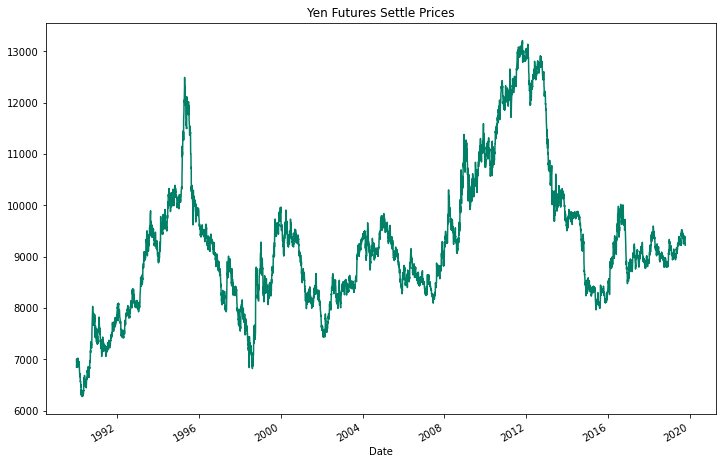

In [145]:
# Plotting the "Settle" column from the dataframe:
yen_futures.Settle.plot(figsize=(12,8), title='Yen Futures Settle Prices', colormap='summer')

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, I decomposed the Settle price into a trend and noise.

In [12]:
import statsmodels.api as sm
# Applied the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:

yen_noise, yen_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [47]:
# Created a dataframe of the settle price, and added columns for "noise" and "trend" series from above:
df = pd.concat([yen_futures['Settle'], yen_noise, yen_trend], axis=1)
df.columns = ['Settle', 'noise', 'trend'] 
df2 = pd.concat([yen_futures['Settle'], yen_trend], axis=1)
df2.columns = ['Settle', 'trend'] 
df.head()

,Settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


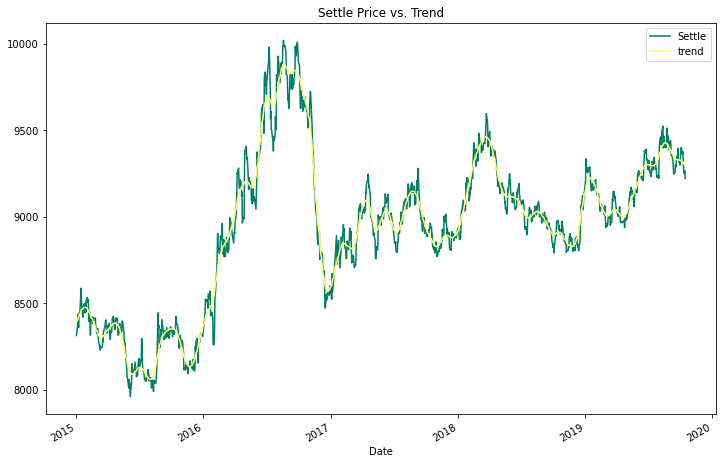

In [138]:
# Plotting the Settle Price vs. the Trend for 2015 to the present
settle_v_trend = df2['2015':]
settle_v_trend.plot(figsize=(12,8), title='Settle Price vs. Trend', colormap='summer')

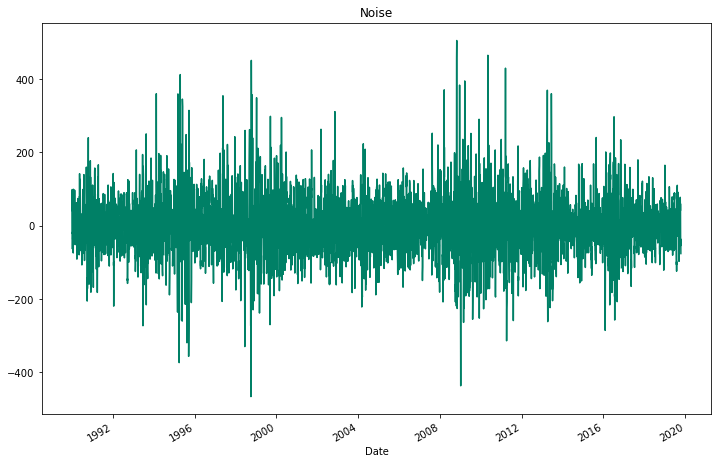

In [146]:
# Plotting the Settle Noise
yen_noise.plot(figsize=(12,8), title='Noise', colormap='summer')

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, I estimated an ARMA model

1. ARMA: Created an ARMA model and fit it to the returns data. Note: The AR and MA ("p" and "q") parameters are set to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table while taking note of the p-values of the lags. Based on the p-values, p > 0.05. 
3. Plotted the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [82]:
# Created a series using "Settle" price percentage returns, dropped any nans

returns = (df[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [87]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimated an ARMA model using statsmodels (used order=(2, 1))

arma_model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
# YOUR CODE HERE!
arma_results = arma_model.fit()

In [89]:
# Outputting model summary results:

arma_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Sat, 27 Feb 2021   AIC                          15798.142
Time:                        00:59:38   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3059      1.278     -0.239      0.811      -2.810       2.198
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2944      1.278      0.230      0.818      -2.210       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3382           +0.0000j            3.3382            0.5000
AR.2         -157.3438           +0.0000j          157.3438            0.5000
MA.1           -3.3973           +0.0000j            3.3973            0.5000
-----------------------------------------------------------------------------
"""

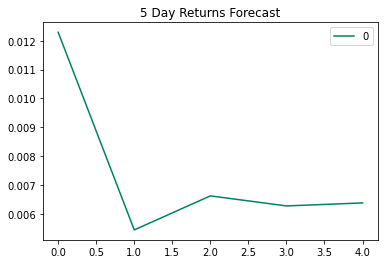

In [141]:
# Plotting the 5 Day Returns Forecast

pd.DataFrame(arma_results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast", colormap='summer')

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, I estimated an ARIMA model.
     1. Setting P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, p > 0.05.
 3. Constructed a 5 day forecast for the Settle Price.

In [69]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:

model = ARIMA(df['Settle'], order=(5, 1, 1))

# Fit the model

results = model.fit()

/Users/admin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/admin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [71]:
# Output of model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Sat, 27 Feb 2021   AIC                          83905.238
Time:                        00:39:35   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3158      0.700      0.451      0.652      -1.056       1.688
ar.L1.D.Settle     0.2814      0.699      0.402      0.688      -1.090       1.652
ar.L2.D.Settle     0.0007      0.016      0.042      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0127      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.890      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.066      0.948      -0.036       0.034
ma.L1.D.Settle    -0.2964      0.699     -0.424      0.672      -1.667       1.074
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8905           -1.3790j            2.3400           -0.1003
AR.2            1.8905           +1.3790j            2.3400            0.1003
AR.3           -2.2637           -3.0253j            3.7785           -0.3522
AR.4           -2.2637           +3.0253j            3.7785            0.3522
AR.5          -10.8643           -0.0000j           10.8643           -0.5000
MA.1            3.3740           +0.0000j            3.3740            0.0000
-----------------------------------------------------------------------------
"""

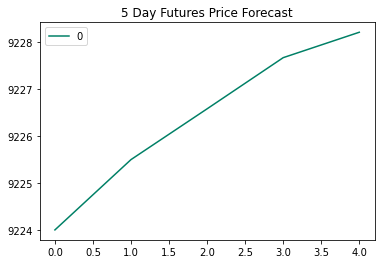

In [148]:
# Plotting the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast", colormap='summer')

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [94]:
import arch 
from arch import arch_model

In [95]:
# Estimate a GARCH model:

garch_model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model

res = garch_model.fit(disp="off")

In [97]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Sat, Feb 27 2021   Df Residuals:                     7514
Time:                        01:04:19   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [98]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [118]:
# Creating a 5 day forecast of volatility
forecast_horizon = 252
# Starting the forecast using the last_day calculated above
forecasts = res.forecast(start='2009-10-15', horizon=5)
forecasts

In [119]:
# Annualizing the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2009-10-15,11.079613,11.082356,11.085076,11.087772,11.090446
2009-10-16,10.904145,10.908402,10.912622,10.916805,10.920951
2009-10-19,10.715145,10.721061,10.726924,10.732735,10.738495
2009-10-20,10.515197,10.522902,10.530537,10.538102,10.545600
2009-10-21,10.388074,10.396935,10.405714,10.414414,10.423033


In [120]:
# Transposing the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2009-10-15,2009-10-16,2009-10-19,2009-10-20,2009-10-21,2009-10-22,2009-10-23,2009-10-26,2009-10-27,2009-10-28,...,2019-10-02,2019-10-03,2019-10-04,2019-10-07,2019-10-08,2019-10-09,2019-10-10,2019-10-11,2019-10-14,2019-10-15
h.1,11.079613,10.904145,10.715145,10.515197,10.388074,10.234766,10.431030,10.246898,10.177838,10.541108,...,7.601849,7.537719,7.434147,7.445512,7.363772,7.376203,7.367164,7.476237,7.389298,7.434048
h.2,11.082356,10.908402,10.721061,10.522902,10.396935,10.245042,10.439498,10.257061,10.188645,10.548578,...,7.641259,7.577994,7.475842,7.487050,7.406448,7.418705,7.409793,7.517352,7.431617,7.475745
h.3,11.085076,10.912622,10.726924,10.530537,10.405714,10.255222,10.447889,10.267129,10.199351,10.555981,...,7.680141,7.617725,7.516963,7.528017,7.448528,7.460615,7.451826,7.557905,7.473348,7.516867
h.4,11.087772,10.916805,10.732735,10.538102,10.414414,10.265308,10.456204,10.277104,10.209957,10.563318,...,7.718507,7.656922,7.557521,7.568425,7.490024,7.501945,7.493278,7.597907,7.514502,7.557426
h.5,11.090446,10.920951,10.738495,10.545600,10.423033,10.275299,10.464443,10.286987,10.220464,10.570589,...,7.756366,7.695596,7.597528,7.608284,7.530950,7.542708,7.534159,7.637369,7.555094,7.597434


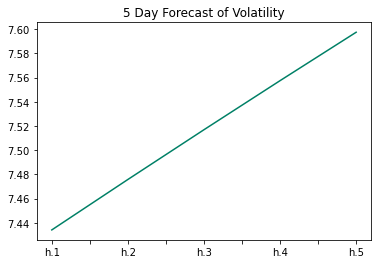

In [147]:
# Plotting the final forecast
final['2019-10-15'].plot(title='5 Day Forecast of Volatility', colormap='summer')

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?